# Описание
Пробую бинарную классификацию по признаку прироста за период в %

# Import modules

In [1]:
# for use R2Score metrics
# !pip install tf-nightly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

# Load Data

In [3]:
data = pd.read_parquet('..\ETH-Full-1H.parquet')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [5]:
data

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


# Feature Enginiring

In [6]:
close_1 = data['Close'].shift(1)
data['Return'] = (data['Close'] / close_1 - 1) * 100

In [7]:
data

,Open,High,Low,Close,Volume,Trades,Return
Datetime,,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131,NaN
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262,0.676545
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225,-0.125201
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138,-0.005117
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128,-0.135598
...,...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648,-0.015162
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445,0.129976
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824,0.312079


In [8]:
data.dropna(inplace=True)

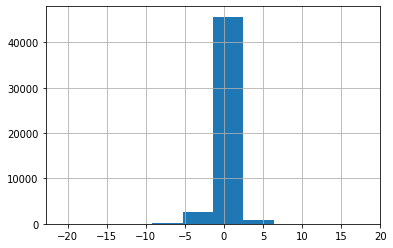

In [9]:
data['Return'].hist();

In [10]:
data['Return'].describe()

count    49336.000000
mean         0.009111
std          1.088287
min        -20.872775
25%         -0.385067
50%          0.007945
75%          0.415860
max         18.079244
Name: Return, dtype: float64

## Create Return as Category Target

In [11]:
data['Return_cat'] = np.where(data['Return'] > 0, 1, 0)

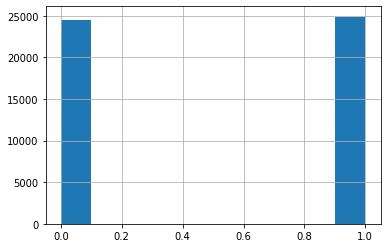

In [12]:
data['Return_cat'].hist();

In [13]:
data['Return_cat'].value_counts(True) * 100

Return_cat
1    50.46011
0    49.53989
Name: proportion, dtype: float64

В таком виде классы достаточно сбалансированны, вопрос что будет после разделения

# Create dataset
## Define features and targets

In [14]:
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Trades']].values
targets = data['Return_cat'].values

## Build Data
Define data dimension

In [15]:
T = 10 # len of sequence. Num of time steps to look at to make prediction on next step
D = features.shape[1] # Num of columns in input data. Features number.
N = features.shape[0] - T # Num of samples in dataset

In [16]:
X = np.zeros((N, T, D))
y = np.zeros(N)

for t in range(N):
  X[t, :, :] = features[t:t+T]
  y[t] = targets[t+T]

In [17]:
data.head(11)

,Open,High,Low,Close,Volume,Trades,Return,Return_cat
Datetime,,,,,,,,
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262,0.676545,1
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225,-0.125201,0
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138,-0.005117,0
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128,-0.135598,0
2017-09-01 05:00:00,388.92,388.99,384.88,384.88,203.48452,194,-1.396254,0
2017-09-01 06:00:00,386.70,388.62,383.18,384.52,85.07529,63,-0.093536,0
2017-09-01 07:00:00,386.26,390.56,384.00,388.40,330.22597,226,1.009050,1
2017-09-01 08:00:00,389.48,393.08,388.16,389.68,270.82415,209,0.329557,1
2017-09-01 09:00:00,389.97,392.00,387.46,389.14,248.32828,248,-0.138575,0


## Split Data

In [18]:
train_size = 0.66

# Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и столбец с правильным ответами
    train_size=train_size, # размер тестовой выборки
    shuffle=True # пока не перемешиваю выборку попро
)

# Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (32555, 10, 6)
Test shape: (16771, 10, 6)


## Normalization Data

In [19]:
# Create the scaler
scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()

# Assuming X_train and X_test have shape (samples, len of sequence, num of features)
num_samples_train = X_train.shape[0]
num_samples_test = X_test.shape[0]

# Flatten the width and height dimensions
X_train_flattened = X_train.reshape(num_samples_train, -1)
X_test_flattened = X_test.reshape(num_samples_test, -1)

# Fit it to the training data
scaler.fit(X_train_flattened)

# Scale the flattened data
X_train_scaled = scaler.transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Reshape the scaled data back to the original shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# LSTM model Binary Classification

Вопрос - а как определять количество юнитов в слоях и глубину нейронки, количество слоев.

In [20]:
i = Input(shape=(T, D))
x = LSTM(100)(i)
x = Dense(1, activation='sigmoid')(x)  # можно использовать softmax, тогда на указать в выходном слое К=2 вместо 1

model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

## Train model

In [21]:
r = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    epochs=50)

Epoch 1/50
1018/1018 [==============================] - 8s 6ms/step - loss: 0.6950 - accuracy: 0.4924 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 2/50
1018/1018 [==============================] - 6s 5ms/step - loss: 0.6937 - accuracy: 0.4986 - val_loss: 0.6935 - val_accuracy: 0.4972
Epoch 3/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.6935 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5067
Epoch 4/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.6936 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.5044
Epoch 5/50
1018/1018 [==============================] - 6s 6ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5058
Epoch 6/50
1018/1018 [==============================] - 6s 6ms/step - loss: 0.6934 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4963
Epoch 7/50
1018/1018 [==============================] - 7s 7ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6934 - val_accuracy:

## Learning Curve

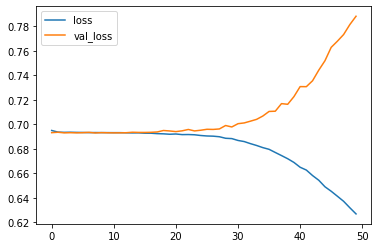

In [24]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

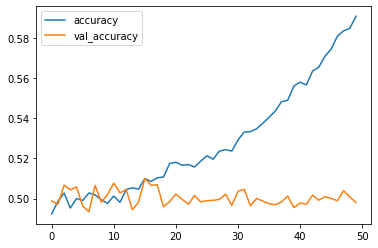

In [25]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend();

Модель вообще не показывает улучшения на валидационной выборке.
Accuracy на валидационной выборке болтается около 50%, но при этом уверенно растет на тренировочной выборке.
Значит модель подстроилась под шум.